In [3]:
from funcs.CSIFuncs import *
from funcs.HelperFuncs import *

from multiprocessing import Pool
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

%matplotlib inline

pd.options.display.float_format = '{:6f}'.format

import warnings
warnings.filterwarnings("ignore")


## Setting configs


In [4]:
# Directory storing the CSI and WLAN captures
resources_dir = "/Volumes/tim_details/tim_honours/CAPTURES"

# Directory to save plots to
plt_dir = "/Users/timothylee/Desktop/Uni/Yr5/Honours/honours_thesis/figures/plt_figs/"

# Supress pd scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Resolution of plots
plt.rcParams["figure.dpi"] = 100 # 300

# Backend to generate plots
# mpl.use("agg")
# %matplotlib ipympl
%matplotlib inline

# plt figure style
fig_style = "seaborn-v0_8-whitegrid"

# colormaps
cmap_qual = plt.get_cmap("Pastel1")
cmap_seq = plt.get_cmap("viridis")
cmap_cycl = plt.get_cmap("twilight")


## Storing CSI data as h5 tables

In [9]:
procs = 4

dirs = glob("/Volumes/tim_details/tim_honours/CAPTURES/*/*")

for dir in dirs:
    # Setting up dirs
    clean_dir_junk(os.path.join(dir, "csi"))
    make_dir(os.path.join(dir, "csi_h5"))
    # Running multiprocessing: csi pcap to h5
    starargs = [(dir, get_name(i)) for i in os.listdir(os.path.join(dir, "csi"))]
    with Pool(procs, initializer=csi_to_df_init_mp) as pool:
        pool.starmap(csi_to_df_mp, starargs)

/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=A3gUpodXMv0 - cap_15
/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=A3gUpodXMv0 - cap_82
/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=A3gUpodXMv0 - cap_94
/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=A3gUpodXMv0 - cap_59
/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=A3gUpodXMv0 - cap_72
/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=A3gUpodXMv0 - cap_23
/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=A3gUpodXMv0 - cap_19
/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=A3gUpodXMv0 - cap_76
/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=A3gUpodXMv0 - cap_26
/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=A3gUpodXMv0 - cap_28
/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=A3gUpodXMv0 - cap_35
/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=A3gUpodXMv0 - cap_46
/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=A3gUpod

## Reading and Processing Nexmon CSI PCAP files


In [ ]:
# Reading csi info (including metadata)
frames = read_csi(csi_fp)
# Checking that the CSI is valid before continuing
if check_csi(frames["csi"]):
    # Processing csi info
    csi = process_csi(frames["csi"], True, True, 5)
    # Making csi amplitude plots
    # fig, axes = CSIFuncs.plot_all(csi)
    # fig.savefig(plot_fp)
    # plt.close(fig)

## Analysing CSI time-series characteristics (packets per second)

KeyError: 'ts_sec_comb'

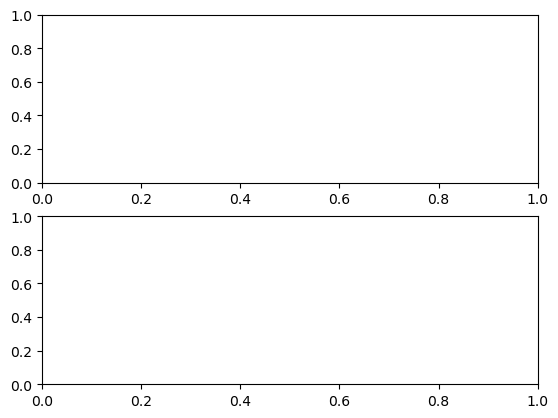

In [2]:
def csi_timeseries(fps):
    fig, axes = plt.subplots(nrows=2)
    for fp in fps:
        # Reading csi info (including metadata)
        frames = read_csi(fp)
        # Checking that the CSI is valid before continuing
        if check_csi(frames["csi"]):
            # Processing csi info
            csi = process_csi(frames["csi"], True, True, 5)
        else:
            continue

        # Setting up single capture dataframe
        df = pd.DataFrame(
            {   
                "ts_sec_comb": frames["ts_sec_comb"] - frames["ts_sec_comb"][0],
            },
        )
        # Adding CSI subcarrier vals as columns
        for i in np.arange(csi.shape[1]):
            df[f"subc_{i+1}"] = csi[:, i]

        # Generating time-bins
        interval = 1
        series = df["ts_sec_comb"]
        start = np.floor(series.min())
        end = np.ceil(series.max()) + interval
        bins = np.arange(start, end, interval)
        df["ts_bin"] = pd.cut(series, bins=bins, include_lowest=True, labels=bins[:-1])

        # Grouping and aggregating data on time bins
        agg_dict = {"ts_sec_comb": "count"}
        for i in np.arange(csi.shape[1]):
            agg_dict[f"subc_{i+1}"] = lambda x: np.nanmean(np.abs(x))
        df_binned = df.groupby("ts_bin").agg(agg_dict)
        # df_binned = df_binned.fillna(0)
        df_binned = df_binned.interpolate(method="linear", axis=0)
        df_binned = df_binned.sort_index()
        df_binned["ts_sec_comb_cumsum"] = df_binned["ts_sec_comb"].cumsum()

        # Visualising data:
        # Cumulative packets across time bins
        axes[0].plot(
            df_binned.index,
            df_binned["ts_sec_comb_cumsum"],
        )
        # CSI amplitudes across time (averaged within time bins)
        csi_cols = [f"subc_{i+1}" for i in np.arange(csi.shape[1])]
        axes[1].pcolormesh(
            df_binned[csi_cols].T,
        )
    return fig, axes


fps = glob("/Volumes/tim_details/tim_honours/CAPTURES/client_pc_200/v=A3gUpodXMv0/csi/cap_*.pcap")[:3]
fig, axes = csi_timeseries(fps)


## Getting summaries of CSI data

In [ ]:
# GETTING SUMMARIES OF A DIRECTORY OF CAPTURES:
# nfiles, nframes, statistics
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import CSIFuncs

dirs = glob("/Volumes/tim_details/tim_honours/CAPTURES/*/*")
dirs = ["/Volumes/tim_details/tim_honours/CAPTURES/client_pi_200/v=mkWKZWMokdI"]

# Getting a summary of each different CSI experiment setup
res_arr = {}
for dir in dirs:
    print(dir)
    fps = glob(os.path.join(dir, "csi/*"))
    res_arr[dir] = CSIFuncs.get_summaries(fps)

fig, ax = plt.subplots()
for i in res_arr:
    res = res_arr[i]
    ax.hist(
        res["nframes"],
        alpha=0.2,
        label=f"{i}",
    )
# plt.legend()

## Combining CSI from each label combination into an array of 2D arrays
- 0 axis: The individual csi capture matrix (i.e. the file)
- 1 axis: The frames (note: must be trimmed or padded - same size across all)
- 2 axis: The subcarrier


In [ ]:
import pandas as pd
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

dirs = glob("/Volumes/tim_details/tim_honours/CAPTURES/*/*")
nframes = 10000

for dir in dirs:
    print(dir)
    fps = glob(os.path.join(dir, "csi/*"))
    comb_csi = CSIFuncs.combine_csis(fps, nframes)
    np.save(os.path.join(dir, "csi_all.npy"), comb_csi)

# fig, ax = plt.subplots()
# CSIFuncs.hist2d_subc(np.abs(csi), fig, ax)
# fig, ax = plt.subplots()
# CSIFuncs.hist2d_complex(csi, fig, ax)
# CSIFuncs.plot_all(csi)